# ROC curves and accuracy curves (HST training set)

In this notebook we show ROC curves and accuracy curves of several star/galaxy separation models: the machine leaarning model, the simple model (based on wwpsfKronDist), and PS1 model (based on $m_{\mathrm{iPSF}} - m_{\mathrm{iKron}}$). 

Simple model outperforms PS1 model, and the machine learning model shows the best performance in all range of brightness.

In [40]:
import sys,os,math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
from matplotlib import gridspec as grs
from matplotlib import cm
from matplotlib.legend import Legend
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from astropy.table import Table
import seaborn as sns
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from numpy import interp

%matplotlib inline

Functions to plot ROC curves and accuracy curves.  

In [41]:
def calc_CV_ROC(features, GT, score, n_splits, ML=False, classifier=None):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    mean_fpr = np.linspace(0, 1, 5000)

    i = 0
    print('\n CV: ', end=' ')
    for train, test in cv.split(features, GT):
        print('%d/%d, '%(i+1, n_splits), end='')
        X_train, X_test, y_train, y_test = features[train], features[test], GT[train], GT[test]
        if ML: 
            score = np.array(classifier.fit(X_train, y_train).predict_proba(X_test))
            score = score[:, 1]            
            fpr, tpr, thresholds = roc_curve(y_test, score)
        else:
            fpr, tpr, thresholds = roc_curve(y_test, np.array(score)[test])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    std_tpr = np.std(tprs, axis=0)/np.sqrt(n_splits)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    return(mean_fpr, mean_tpr, tprs_lower, tprs_upper)

def plot_ROC_curves(catalog, features, GT, n_splits, classifier, 
                    figname, savefig, 
                    extent =  [0, 1, 0, 1], extent_ins = [3e-3, 0.98e-2, 0.5, 0.7]):
    
    ML_mean_fpr, ML_mean_tpr, ML_tprs_lower, ML_tprs_upper =\
        calc_CV_ROC(np.array(features), GT, None, n_splits, ML=True, classifier=classifier)    
    dist_mean_fpr, dist_mean_tpr, dist_tprs_lower, dist_tprs_upper =\
        calc_CV_ROC(np.array(features), GT, catalog.wwFPSFApDist, n_splits)
    i_mean_fpr, i_mean_tpr, i_tprs_lower, i_tprs_upper =\
        calc_CV_ROC(np.array(features), GT, -catalog.iFPSFminusFKron, n_splits)
    
    col_ML = 'black'
    col_dist = "C0"
    col_iminus = "C1"
    col_star = 'red'

    fig, ax = plt.subplots(figsize=(8, 5))
    axins = inset_axes(ax, width="58.5%",  
                       height="67.5%", loc=5)

    ax.grid(alpha=0.5, lw=0.5, c='grey', linestyle=':') 
    ax.tick_params(which="both", top=True, right=True)
    ax.minorticks_on()
    
    ax.fill_between(ML_mean_fpr, ML_tprs_lower, ML_tprs_upper, color=col_ML, alpha=.5)
    ax.fill_between(dist_mean_fpr, dist_tprs_lower, dist_tprs_upper, color=col_dist, alpha=.5)
    ax.fill_between(i_mean_fpr, i_tprs_lower, i_tprs_upper, color=col_iminus, alpha=.5)
    ax.plot(ML_mean_fpr, ML_mean_tpr, color=col_ML, lw=1, label='ML model')
    ax.plot(dist_mean_fpr, dist_mean_tpr, color=col_dist, lw=1, label='Simple model')
    ax.plot(i_mean_fpr, i_mean_tpr, color=col_iminus, lw=1, label='PS1 model')# label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
    #ax.plot(i_mean_fpr[np.argmin(np.abs(i_thre--0.05))], 
    #    i_tpr[np.argmin(np.abs(i_thre--0.05))], '*', color=col_star_dist)

    ax.set_xlim(extent[0:2]); ax.set_ylim(extent[2:4])
    ax.tick_params(labelsize = 15)
    ax.set_xlabel('False Positive Ratio', fontsize=15)
    ax.set_ylabel('True Positive Ratio', fontsize=15)

    ax.legend( bbox_to_anchor=(0.01, 0.01, 1., 0.102), 
              loc=3, borderaxespad=0, fontsize=13)
    
    origin = 'lower'
    axins.tick_params(which="both", top=True)
    axins.minorticks_on()
    axins.fill_between(ML_mean_fpr, ML_tprs_lower, ML_tprs_upper, color=col_ML, alpha=.5)
    axins.fill_between(dist_mean_fpr, dist_tprs_lower, dist_tprs_upper, color=col_dist, alpha=.5)
    axins.fill_between(i_mean_fpr, i_tprs_lower, i_tprs_upper, color=col_iminus, alpha=.5)
    axins.plot(ML_mean_fpr, ML_mean_tpr, color=col_ML, lw=1.5)
    axins.plot(dist_mean_fpr, dist_mean_tpr, color=col_dist, lw=1.5)
    axins.plot(i_mean_fpr, i_mean_tpr, color=col_iminus, lw=1.5)
    axins.vlines([5e-3], 1e-3, 1, color='grey', lw=0.5)
    axins.set_xlim(extent_ins[0:2]); axins.set_ylim(extent_ins[2:4])
    axins.tick_params(labelsize = 15)
    plt.tight_layout()
    
    if savefig: 
        plt.savefig(figname)
    
    plt.show()
    
    return(None)

def calc_separtion_thre(thre, tpr, fpr, method):
    if method == 'info':
        return(thre[(tpr-fpr)==np.max(tpr-fpr)]-1e-10)
    if method == 'fom':
        return(thre[np.argmin(np.abs(fpr-0.005))])

def make_separation_label(thre, proba):
    return((np.sign(proba - thre).astype(int) + 1)/2)

def calc_accuracy_error(GT, labels, Xval, Xmin, Xmax, binwidth = 0.5, Nboot = 1):
    X_array = np.arange(Xmin , Xmax+binwidth, binwidth)
    acc_arr = np.zeros_like(X_array)
    boot_scatt = np.vstack((np.zeros_like(X_array), np.zeros_like(X_array)))

    for bin_num, binedge in enumerate(X_array):
        bin_sources = np.where((Xval >= binedge) & (Xval < binedge + binwidth))
        acc_arr[bin_num] = accuracy_score(GT[bin_sources], 
                                               labels[bin_sources])
        boot_acc = np.empty(Nboot)
        for i in range(Nboot):
            boot_sources = np.random.choice(bin_sources[0], len(bin_sources[0]))
            boot_acc[i] = accuracy_score(GT[boot_sources], 
                                                   labels[boot_sources])

        boot_scatt[:,bin_num] = np.percentile(boot_acc, [16, 84])
    return(X_array+binwidth/2, acc_arr, boot_scatt)

def calc_CV_accuracy(features, catalog, GT, labels, Xval, Xmin, Xmax, binwidth = 0.5, n_splits=10, ML=False, classifier=None):
    cv = StratifiedKFold(n_splits=n_splits)
    X_array = np.arange(Xmin , Xmax+binwidth, binwidth)
    acc_arr = np.zeros_like(X_array)
    cv_tab = np.zeros((len(X_array), n_splits))
    
    i=0
    for train, test in cv.split(features, GT):
        print(i, end='')
        if ML: 
            X_train, X_test, y_train, y_test = \
                np.array(features)[train], np.array(features)[test], np.array(GT)[train], np.array(GT)[test]
            labels = classifier.fit(X_train, y_train).predict(X_test)
        boot_acc = np.empty(len(X_array))
        for bin_num, binedge in enumerate(X_array):
            bin_sources = np.where((np.array(Xval)[test] >= binedge) & (np.array(Xval)[test] < binedge + binwidth))
            if ML: 
                boot_acc[bin_num] = accuracy_score(y_test[bin_sources], labels[bin_sources])
            else: 
                boot_acc[bin_num] = accuracy_score(np.array(GT)[test][bin_sources], np.array(labels)[test][bin_sources])
        cv_tab[:, i] = boot_acc
        i += 1
    cv_mean = np.mean(cv_tab, axis=1)
    cv_std = np.std(cv_tab, axis=1)/np.sqrt(n_splits)
    return(X_array+binwidth/2, cv_mean, cv_std)

def plot_ACU_curves(features, catalog, GT, figname, savefig, thre_method='info'):
    
    wwKronMag =  -2.5*np.log10(catalog.wwFKronFlux/3631)
    wwApMag =  -2.5*np.log10(catalog.wwFApFlux/3631)
    
    #dist_fpr, dist_tpr, dist_thre = roc_curve(GT, catalog.wwPSFKronDist)
    #dist_thre_info  = 9.2e-07 #calc_separtion_thre(dist_thre, dist_tpr, dist_fpr, method=thre_method)

    dist_labels = make_separation_label(9.2e-07, catalog.wwFPSFApDist.values)
    iminus_labels = make_separation_label(-0.05, -catalog.iFPSFminusFKron.values)
    
    print('Calculating the error of the accuracy: ', end='')
    mag_array, ML_acc_arr, ML_boot_scatt = \
        calc_CV_accuracy(features, catalog, GT, None, wwApMag, 14.75, 23.25, ML=True, classifier=classifier)
    mag_array, dist_acc_arr, dist_boot_scatt = \
        calc_CV_accuracy(features, catalog, GT, dist_labels, wwApMag, 14.75, 23.25)
    mag_array, iminus_acc_arr, iminus_boot_scatt = \
        calc_CV_accuracy(features, catalog, GT, iminus_labels, wwApMag, 14.75, 23.25)
    print('Done.')
    
    print('Calculating PDFs : ', end='')
    star_norm = np.sum(GT==1)/len(GT)
    gal_norm = np.sum(GT==0)/len(GT)
    
    All_kde = stats.gaussian_kde(wwApMag)
    Star_kde = stats.gaussian_kde(wwApMag[GT==1])
    Gal_kde = stats.gaussian_kde(wwApMag[GT==0])
    n = (np.arange(12,25,0.1))
    All_kde_pdf = All_kde(n)
    Star_kde_pdf = Star_kde(n)*star_norm
    Gal_kde_pdf = Gal_kde(n)*gal_norm
    print('Done.\n')
    
    bias = 0.5

    cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
    cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

    col_ML = 'black'
    col_dist = "C0"
    col_iminus = "C1"

    plt.figure(figsize=(8,5))
    
    plt.fill(n, All_kde_pdf + bias, alpha=0.5, color="0.7", zorder=0)
    plt.fill(n, Gal_kde_pdf + bias, alpha=0.8, color=cmap_gal(0.25), zorder=1)
    plt.fill(n, Star_kde_pdf + bias, alpha=0.8, color=cmap_star(0.25), zorder=2)

    plt.vlines(mag_array, iminus_acc_arr - iminus_boot_scatt,  iminus_acc_arr + iminus_boot_scatt, 
               color=col_iminus, alpha=0.5, linewidth=1, zorder=3)
    plt.vlines(mag_array, dist_acc_arr - dist_boot_scatt, dist_acc_arr + dist_boot_scatt, 
               color=col_dist, alpha=0.5, linewidth=1, zorder=4)
    plt.vlines(mag_array, ML_acc_arr - ML_boot_scatt, ML_acc_arr + ML_boot_scatt, 
               color=col_ML, alpha=0.5, linewidth=1, zorder=5)
    plt.plot(mag_array, dist_acc_arr, color=col_dist, alpha=0.5, linewidth=0.5, zorder=6)
    plt.plot(mag_array, ML_acc_arr, color=col_ML, alpha=0.5, linewidth=0.5, zorder=7)
    plt.plot(mag_array, iminus_acc_arr, color=col_iminus, alpha=0.5, linewidth=0.5, zorder=8)
    plt.scatter(mag_array, ML_acc_arr, color=col_ML, label='ML model', zorder=11)
    plt.scatter(mag_array, dist_acc_arr, color=col_dist, label='Simple model', zorder=10)
    plt.scatter(mag_array, iminus_acc_arr, color=col_iminus, label='PS1 model', zorder=9)#, label = r'm$_{\rm iPSF}-$m$_{\rm iKron}$')

    plt.ylim(bias,1.01)
    plt.xlim(14.5, 24.0)
    plt.legend(bbox_to_anchor=(0.01, 0.3, 1., 0.102), loc=3, fontsize=13)
    plt.tick_params(labelsize = 15, which="both", top=True,  right=True)
    plt.minorticks_on()
    plt.xlabel('whiteKronMag', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.tight_layout()
    
    if savefig:
        plt.savefig(figname)
        
    plt.show()
    return(None)

def check_ROC_Accuracy(TrainingCatalog, TestingCatalog, FeatureNames, TrainingGT, TestingGT, 
                      n_estimators = 250, min_samples_leaf = 1, max_features = 5, 
                      TrainMask=None, TestMask=None,  clean=True, 
                      saveROCfig=True, saveAccuraccyfig=True, FigName='Auto'):
    import warnings
    warnings.filterwarnings('ignore')
    
    print("""Running the model with
    %s
    Using clean dataset = %s 
    Parameters for the random forest classifier: 
    n_estimators = %d 
    min_samples_leaf = %d
    max_features = %d \n""" 
          %(FeatureNames, clean, n_estimators, min_samples_leaf, max_features))
    
    if len(TrainMask) == len(TrainingCatalog):
        TrainingCatalog = TrainingCatalog[TrainMask]
        TrainingGT = TrainingGT[TrainMask]
    if len(TestMask) == len(TestingCatalog):
        TestingCatalog = TestingCatalog[TestMask]
        TestingGT = TestingGT[TestMask]
    
    tr_tab = TrainingCatalog.loc[:,FeatureNames]
    te_tab = TestingCatalog.loc[:,FeatureNames]
    
    print("""Length of the datasets:
    Training: %d 
    Testing: %d \n""" %(len(tr_tab), len(te_tab)))
    
    tr_X = tr_tab.values
    tr_Y = np.squeeze(TrainingGT)
    te_X = te_tab.values
    te_Y = np.squeeze(TestingGT)
        
    print('Training the classifier: ', end='')
    Classifier = RandomForestClassifier(n_estimators = n_estimators, 
                                                        min_samples_leaf = min_samples_leaf, 
                                                        max_features= max_features, n_jobs=-1).fit(tr_X, tr_Y)
    print('Done.\n')
    
    if  FigName=='Auto':
        figname = str(n_estimators) + '_' + str(min_samples_leaf) + '_' + str(max_features)
        if clean:
            figname = figname + '_clean'
        ROC_figname = 'ROC_' + figname + '.pdf'
        ACU_figname = 'ACU_' + figname + '.pdf'
                                        
    ML_predict = Classifier.predict_proba(te_X)
    print('Plotting ROC curves: ')
    plot_ROC_curves(TestingCatalog, te_Y, ML_predict[:,1], ROC_figname, saveROCfig)
    print('Plotting accuracy curves: ')
    plot_ACU_curves(TestingCatalog, te_Y, ML_predict[:,1], ACU_figname, saveAccuraccyfig)
    
    return(None)

In [42]:
hst_tab = Table.read("/home/xhall/Documents/PS1CrossMatch/PS1_star_galaxy_0.adamamiller_0.HST_COSMOS_Forcefeatures_xhall_0.fit").to_pandas()

In [43]:
hst_tab["wwFApKronRatio"] = hst_tab["wwFApFlux"] / hst_tab["wwFKronFlux"] 

In [44]:
a = 0.7459999999999999
hst_tab["wwFApKronDist"] = (hst_tab["wwFApFlux"] - a * hst_tab["wwFKronFlux"])/(np.sqrt(1+a**2))

In [45]:
hst_tab.iloc[0:5]

,CLASS_STAR,MU_CLASS,objid,raStack,decStack,nDetections,qualityFlag,iFPSFminusFKron,wwFPSFFlux,wwFKronFlux,...,wwE2,wwFPSFKronDist,wwFPSFApDist,wwFPSFApRatio,wwFPSFKronRatio,wwFPSFflxR5Ratio,wwFPSFflxR6Ratio,wwFPSFflxR7Ratio,wwFApKronRatio,wwFApKronDist
0,0.000462,1,110871497088318514,149.708825,2.398398,0,48,-0.065404,0.000004,0.000005,...,0.015440,-1.163475e-07,-6.004763e-07,0.640077,0.721388,0.643918,0.586436,1.123178,1.127033,1.490768e-06
1,0.218015,1,110871497104437385,149.710333,2.397397,1,52,-0.275643,0.000004,0.000004,...,-1.330465,1.019696e-06,1.140512e-06,1.201416,1.089794,1.940570,3.513087,-0.632060,0.907092,4.863483e-07
2,0.023310,1,110871497129613779,149.713008,2.394552,1,165,-0.239731,0.000003,0.000011,...,-0.022966,-4.269568e-06,-1.594144e-06,0.476268,0.280625,0.737970,0.361996,0.178132,0.589217,-1.426061e-06
3,0.028586,1,110871497219828579,149.721869,2.398430,3,52,-0.227333,0.000002,0.000007,...,-0.098363,-2.243692e-06,-1.435647e-06,0.439008,0.342628,0.297958,0.252219,0.117878,0.780459,1.897080e-07
4,0.000599,1,110871497271790831,149.727181,2.392008,0,160,0.374732,0.000002,0.000004,...,0.067410,-4.115860e-07,-7.301604e-07,0.561564,0.618363,0.383816,0.229035,0.098984,1.101145,1.103137e-06


In [46]:
hst_GT = np.array(hst_tab.MU_CLASS - 1, dtype=int)

For a fair comparison between the 3 models we must generate a subset of sources that has a classification from each model. 

In [47]:
hst_det_mask = (hst_tab.nDetections > 0)&(~np.isnan(hst_tab.iFPSFminusFKron))

In [48]:
print("There are {:d} sources in the PS1 subset from HST".format(sum(hst_det_mask)))

There are 46401 sources in the PS1 subset from HST


## Without flux information (All dataset)

In [50]:
fnames = ['E1', 'E2', 'FPSFKronDist',
          'FPSFApDist', 'FPSFApRatio',  'FPSFKronRatio',
          'FPSFflxR5Ratio', 'FPSFflxR6Ratio', 'FPSFflxR7Ratio']
fil = 'ww'
features = [fil  + feat for feat in fnames]

In [51]:
classifier = RandomForestClassifier(n_estimators = 900, 
                                                    min_samples_leaf = 2, 
                                                    max_features= 3, n_jobs=-1, random_state =  20)


 CV:  1/10, 2/10, 3/10, 4/10, 5/10, 6/10, 7/10, 8/10, 9/10, 10/10, 
 CV:  1/10, 2/10, 3/10, 4/10, 5/10, 6/10, 7/10, 8/10, 9/10, 10/10, 
 CV:  1/10, 2/10, 3/10, 4/10, 5/10, 6/10, 7/10, 8/10, 9/10, 10/10, 

/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


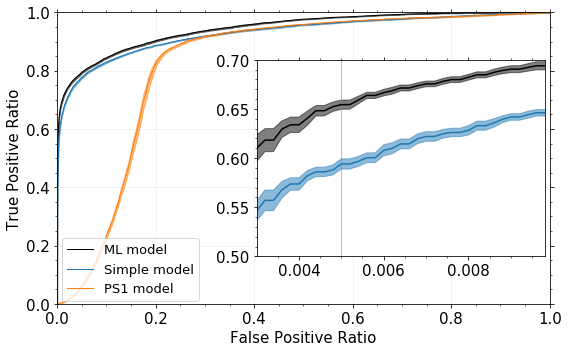

In [52]:
plot_ROC_curves(hst_tab[hst_det_mask], hst_tab[hst_det_mask][features], hst_GT[np.array(hst_det_mask)], 
                n_splits=10, classifier=classifier, figname='CV_ROC_HST.pdf', savefig = False)

The FoM (FPR = 0.005) of the ML model and the simple model is $\sim 0.66$ and $\sim 0.59$, while that of the PS1 model is almost 0. 

### Summary of statistics of CV for the HST training set

In [ ]:
def get_CV_MLpreds(hst_tab, hst_det_mask, feats, n_splits=10, rs=23):
    X_hst = np.array(hst_tab[feats].loc[hst_det_mask])
    y_hst = np.array(hst_tab["MU_CLASS"].loc[hst_det_mask] - 1, dtype=int)
    rf_preds = np.empty_like(y_hst, dtype=float)
    cv = StratifiedKFold(n_splits=n_splits, random_state=rs)
    for train, test in cv.split(X_hst, y_hst):
        rf_preds[test] = classifier.fit(X_hst[train], 
                                        y_hst[train]).predict_proba(X_hst[test])[:,1]
        print(rf_preds[test])
    return y_hst,  rf_preds

def calc_fom(fpr, tpr, thresh, fpr_at=0.005):
    return interp(fpr_at, fpr, thresh), interp(fpr_at, fpr, tpr)

In [54]:
hst_det_mask = (hst_tab.nDetections >= 0)&(~np.isnan(hst_tab.iFPSFminusFKron))
#hst_det_mask = hst_tab.nDetections > 2

hst_det_mask = (hst_tab.nDetections >= 1)&(~np.isnan(hst_tab.iFPSFminusFKron))&(~np.isnan(hst_tab.wwFPSFApDist))

classifier = RandomForestClassifier(n_estimators=1000, 
                                    max_features=10,
                                    min_samples_leaf=2,
                                    n_jobs=-1, 
                                    random_state =  25)

In [55]:
y_hst, rf_preds = get_CV_MLpreds(hst_tab, hst_det_mask, features, n_splits=10, rs=23)

/home/xhall/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[3.70370370e-04 2.21101852e-01 3.76851852e-02 ... 1.00000000e+00
 1.68148148e-02 1.06026455e-01]
[0.02564815 0.0477963  0.00883069 ... 1.         0.99685185 0.48715608]
[0.07971032 0.02381349 0.05333333 ... 0.26090476 1.         1.        ]
[0.23157804 0.03585979 0.0535     ... 0.3999537  0.98881481 1.        ]
[0.09853704 0.01085185 0.02681085 ... 0.7997037  0.9987037  0.04683333]
[0.10783289 0.03841667 0.01811111 ... 0.15044709 0.96972222 0.97956878]
[0.04238624 0.04558995 0.11917328 ... 0.99805556 0.9521164  0.11806349]
[0.09655159 0.05220723 0.1688933  ... 0.06702646 0.00492593 0.04823545]
[0.20857672 0.99888889 0.97992593 ... 0.02587037 0.05986728 0.05770899]
[0.18220194 0.0794418  0.17143298 ... 0.00261111 0.14873148 0.04336111]


In [56]:
rf_fpr, rf_tpr, rf_thresh = roc_curve(y_hst, rf_preds)

In [57]:
kron_mag = np.array(-2.5*np.log10(hst_tab['wwFKronFlux'].loc[hst_det_mask]/3631))
ap_mag = np.array(-2.5*np.log10(hst_tab['wwFApFlux'].loc[hst_det_mask]/3631))

In [58]:
def summary_stats_bootstrap(gt, preds, ct=0.5, fom_at=[0.005, 0.01, 0.02, 0.05, 0.1], Nboot=100, mag_max = 30):
    mag_mask = np.where(ap_mag  < mag_max)
    acc = accuracy_score(gt[mag_mask], preds[mag_mask] >= ct)
    auc = roc_auc_score(gt[mag_mask], preds[mag_mask])
    fpr, tpr, thresh = roc_curve(gt[mag_mask], preds[mag_mask])
    fom_thresh = np.array([calc_fom(fpr, tpr, thresh, f) for f in fom_at])
    thresh = fom_thresh[:,0]
    fom = fom_thresh[:,1]
    acc_std_arr = np.empty(Nboot)
    auc_std_arr = np.empty_like(acc_std_arr)
    fom_std_arr = np.empty((Nboot, len(fom_at)))
    thresh_std_arr = np.empty_like(fom_std_arr)
    for i in range(Nboot):
        boot_sources = np.random.choice(mag_mask[0], len(mag_mask[0]), replace=True)
        auc_std_arr[i] = roc_auc_score(gt[boot_sources], preds[boot_sources])
        acc_std_arr[i] = accuracy_score(gt[boot_sources], preds[boot_sources] >= ct)
        _fpr, _tpr, _thresh = roc_curve(gt[boot_sources], preds[boot_sources])
        _fom_thresh = np.array([calc_fom(_fpr, _tpr, _thresh, f) for f in fom_at])
        thresh_std_arr[i,:] = _fom_thresh[:,0]
        fom_std_arr[i,:] = _fom_thresh[:,1]
    #acc = np.percentile(acc_std_arr, [50] ,axis=0)[0]
    #auc = np.percentile(auc_std_arr, [50] ,axis=0)[0]
    #fom = np.percentile(fom_std_arr, [50] ,axis=0)[0]
    #thresh = np.percentile(thresh_std_arr, [50] ,axis=0)[0]
    #acc = np.average(acc_std_arr,axis=0)
    #auc = np.average(auc_std_arr, axis=0)
    #fom = np.average(fom_std_arr, axis=0)
    #thresh = np.average(thresh_std_arr,axis=0)
    acc_std = np.percentile(acc_std_arr, [5, 95] ,axis=0) #np.std(acc_std_arr)
    auc_std = np.percentile(auc_std_arr, [5, 95] ,axis=0) #np.std(auc_std_arr)
    fom_std = np.percentile(fom_std_arr, [5, 95] ,axis=0) #np.std(fom_std_arr, axis=0)
    thresh_std = np.percentile(thresh_std_arr, [16, 95] ,axis=0) #np.std(thresh_std_arr, axis=0)
    return {'Num': len(ap_mag[mag_mask]), 
                'Acc': acc*100, 
                'AUC': auc, 
                'FoM': fom, 
                'Thresh': thresh, 
                'AccSTD': acc_std*100, 
                'AUCSTD': auc_std, 
                'FoMSTD': fom_std, 
                'ThreshSTD': thresh_std}

In [59]:
stat_all = summary_stats_bootstrap(y_hst, rf_preds, Nboot=100)
stat_21 = summary_stats_bootstrap(y_hst, rf_preds, Nboot=100, mag_max=21)
stat_20 = summary_stats_bootstrap(y_hst, rf_preds, Nboot=100, mag_max=20)

In [60]:
stat_all

{'Num': 74759,
 'Acc': 92.31530651827875,
 'AUC': 0.9060297350956561,
 'FoM': array([0.59474142, 0.62834999, 0.66507316, 0.71592061, 0.76575402]),
 'Thresh': array([0.63461512, 0.50816264, 0.38572247, 0.26672665, 0.19296601]),
 'AccSTD': array([92.1585361 , 92.48144036]),
 'AUCSTD': array([0.90316617, 0.90893313]),
 'FoMSTD': array([[0.58706815, 0.62037747, 0.65671256, 0.70897639, 0.76097436],
        [0.60423778, 0.6360672 , 0.67191708, 0.72281897, 0.7729102 ]]),
 'ThreshSTD': array([[0.62326054, 0.50024927, 0.38122742, 0.26480242, 0.19156626],
        [0.65782788, 0.52160776, 0.39193664, 0.27021465, 0.19430528]])}

In [61]:
print('TPR')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ 
"""%(stat_all['FoM'][0], stat_all['FoMSTD'][1][0]-stat_all['FoM'][0], stat_all['FoMSTD'][0][0]-stat_all['FoM'][0], \
            stat_all['FoM'][1], stat_all['FoMSTD'][1][1]-stat_all['FoM'][1], stat_all['FoMSTD'][0][1]-stat_all['FoM'][1], \
            stat_all['FoM'][2], stat_all['FoMSTD'][1][2]-stat_all['FoM'][2], stat_all['FoMSTD'][0][2]-stat_all['FoM'][2], \
            stat_all['FoM'][3], stat_all['FoMSTD'][1][3]-stat_all['FoM'][3], stat_all['FoMSTD'][0][3]-stat_all['FoM'][3], \
            stat_all['FoM'][4], stat_all['FoMSTD'][1][4]-stat_all['FoM'][4], stat_all['FoMSTD'][0][4]-stat_all['FoM'][4]))

print('Threshold')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ 
"""%(stat_all['Thresh'][0], stat_all['ThreshSTD'][1][0]-stat_all['Thresh'][0], stat_all['ThreshSTD'][0][0]-stat_all['Thresh'][0], \
            stat_all['Thresh'][1], stat_all['ThreshSTD'][1][1]-stat_all['Thresh'][1], stat_all['ThreshSTD'][0][1]-stat_all['Thresh'][1], \
            stat_all['Thresh'][2], stat_all['ThreshSTD'][1][2]-stat_all['Thresh'][2], stat_all['ThreshSTD'][0][2]-stat_all['Thresh'][2], \
            stat_all['Thresh'][3], stat_all['ThreshSTD'][1][3]-stat_all['Thresh'][3], stat_all['ThreshSTD'][0][3]-stat_all['Thresh'][3], \
            stat_all['Thresh'][4], stat_all['ThreshSTD'][1][4]-stat_all['Thresh'][4], stat_all['ThreshSTD'][0][4]-stat_all['Thresh'][4]))

TPR
 $0.595^{+0.009}_{-0.008}$ & $0.628^{+0.008}_{-0.008}$ & $0.665^{+0.007}_{-0.008}$ & $0.716^{+0.007}_{-0.007}$ & $0.766^{+0.007}_{-0.005}$ 

Threshold
 $0.635^{+0.023}_{-0.011}$ & $0.508^{+0.013}_{-0.008}$ & $0.386^{+0.006}_{-0.004}$ & $0.267^{+0.003}_{-0.002}$ & $0.193^{+0.001}_{-0.001}$ 



In [62]:
stat_21

{'Num': 14582,
 'Acc': 97.23631874914278,
 'AUC': 0.9934436378057071,
 'FoM': array([0.85990546, 0.94413408, 0.96347228, 0.97622117, 0.98710786]),
 'Thresh': array([0.93918437, 0.72483952, 0.44507716, 0.20174607, 0.11501108]),
 'AccSTD': array([97.04361542, 97.43519407]),
 'AUCSTD': array([0.99265468, 0.99423867]),
 'FoMSTD': array([[0.82182453, 0.93651146, 0.96008269, 0.97343387, 0.98500754],
        [0.90137059, 0.94964999, 0.96867418, 0.97882488, 0.98905685]]),
 'ThreshSTD': array([[0.90038703, 0.68613001, 0.39812365, 0.19626481, 0.11203635],
        [0.9584491 , 0.77431798, 0.49270338, 0.21265946, 0.11816341]])}

In [63]:
print('TPR')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ 
"""%(stat_21['FoM'][0], stat_21['FoMSTD'][1][0]-stat_21['FoM'][0], stat_21['FoMSTD'][0][0]-stat_21['FoM'][0], \
            stat_21['FoM'][1], stat_21['FoMSTD'][1][1]-stat_21['FoM'][1], stat_21['FoMSTD'][0][1]-stat_21['FoM'][1], \
            stat_21['FoM'][2], stat_21['FoMSTD'][1][2]-stat_21['FoM'][2], stat_21['FoMSTD'][0][2]-stat_21['FoM'][2], \
            stat_21['FoM'][3], stat_21['FoMSTD'][1][3]-stat_21['FoM'][3], stat_21['FoMSTD'][0][3]-stat_21['FoM'][3], \
            stat_21['FoM'][4], stat_21['FoMSTD'][1][4]-stat_21['FoM'][4], stat_21['FoMSTD'][0][4]-stat_21['FoM'][4]))

print('Threshold')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ 
"""%(stat_21['Thresh'][0], stat_21['ThreshSTD'][1][0]-stat_21['Thresh'][0], stat_21['ThreshSTD'][0][0]-stat_21['Thresh'][0], \
            stat_21['Thresh'][1], stat_21['ThreshSTD'][1][1]-stat_21['Thresh'][1], stat_21['ThreshSTD'][0][1]-stat_21['Thresh'][1], \
            stat_21['Thresh'][2], stat_21['ThreshSTD'][1][2]-stat_21['Thresh'][2], stat_21['ThreshSTD'][0][2]-stat_21['Thresh'][2], \
            stat_21['Thresh'][3], stat_21['ThreshSTD'][1][3]-stat_21['Thresh'][3], stat_21['ThreshSTD'][0][3]-stat_21['Thresh'][3], \
            stat_21['Thresh'][4], stat_21['ThreshSTD'][1][4]-stat_21['Thresh'][4], stat_21['ThreshSTD'][0][4]-stat_21['Thresh'][4]))

TPR
 $0.860^{+0.041}_{-0.038}$ & $0.944^{+0.006}_{-0.008}$ & $0.963^{+0.005}_{-0.003}$ & $0.976^{+0.003}_{-0.003}$ & $0.987^{+0.002}_{-0.002}$ 

Threshold
 $0.939^{+0.019}_{-0.039}$ & $0.725^{+0.049}_{-0.039}$ & $0.445^{+0.048}_{-0.047}$ & $0.202^{+0.011}_{-0.005}$ & $0.115^{+0.003}_{-0.003}$ 



In [64]:
stat_20

{'Num': 6966,
 'Acc': 98.92334194659776,
 'AUC': 0.997169793030594,
 'FoM': array([0.87592475, 0.94800254, 0.99260199, 0.99661805, 0.99873177]),
 'Thresh': array([0.98112202, 0.94242044, 0.34598439, 0.15509251, 0.06595062]),
 'AccSTD': array([98.73600345, 99.153029  ]),
 'AUCSTD': array([0.99599911, 0.99838242]),
 'FoMSTD': array([[0.7594698 , 0.91391203, 0.99010002, 0.99467426, 0.99784686],
        [0.94185533, 0.9917045 , 0.99542584, 0.99788295, 0.99938145]]),
 'ThreshSTD': array([[0.9606859 , 0.66418035, 0.29743491, 0.14346216, 0.06094126],
        [0.9933023 , 0.96794446, 0.49454752, 0.18708543, 0.07831343]])}

In [65]:
print('TPR')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ 
"""%(stat_20['FoM'][0], stat_20['FoMSTD'][1][0]-stat_20['FoM'][0], stat_20['FoMSTD'][0][0]-stat_20['FoM'][0], \
            stat_20['FoM'][1], stat_20['FoMSTD'][1][1]-stat_20['FoM'][1], stat_20['FoMSTD'][0][1]-stat_20['FoM'][1], \
            stat_20['FoM'][2], stat_20['FoMSTD'][1][2]-stat_20['FoM'][2], stat_20['FoMSTD'][0][2]-stat_20['FoM'][2], \
            stat_20['FoM'][3], stat_20['FoMSTD'][1][3]-stat_20['FoM'][3], stat_20['FoMSTD'][0][3]-stat_20['FoM'][3], \
            stat_20['FoM'][4], stat_20['FoMSTD'][1][4]-stat_20['FoM'][4], stat_20['FoMSTD'][0][4]-stat_20['FoM'][4]))

print('Threshold')
print(""" $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & \
$%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$ & $%1.3f^{+%1.3f}_{%1.3f}$  
"""%(stat_20['Thresh'][0], stat_20['ThreshSTD'][1][0]-stat_20['Thresh'][0], stat_20['ThreshSTD'][0][0]-stat_20['Thresh'][0], \
            stat_20['Thresh'][1], stat_20['ThreshSTD'][1][1]-stat_20['Thresh'][1], stat_20['ThreshSTD'][0][1]-stat_20['Thresh'][1], \
            stat_20['Thresh'][2], stat_20['ThreshSTD'][1][2]-stat_20['Thresh'][2], stat_20['ThreshSTD'][0][2]-stat_20['Thresh'][2], \
            stat_20['Thresh'][3], stat_20['ThreshSTD'][1][3]-stat_20['Thresh'][3], stat_20['ThreshSTD'][0][3]-stat_20['Thresh'][3], \
            stat_20['Thresh'][4], stat_20['ThreshSTD'][1][4]-stat_20['Thresh'][4], stat_20['ThreshSTD'][0][4]-stat_20['Thresh'][4]))

TPR
 $0.876^{+0.066}_{-0.116}$ & $0.948^{+0.044}_{-0.034}$ & $0.993^{+0.003}_{-0.003}$ & $0.997^{+0.001}_{-0.002}$ & $0.999^{+0.001}_{-0.001}$ 

Threshold
 $0.981^{+0.012}_{-0.020}$ & $0.942^{+0.026}_{-0.278}$ & $0.346^{+0.149}_{-0.049}$ & $0.155^{+0.032}_{-0.012}$ & $0.066^{+0.012}_{-0.005}$  



### Accuracy

Calculating the error of the accuracy: 012345678901234567890123456789Done.
Calculating PDFs : Done.



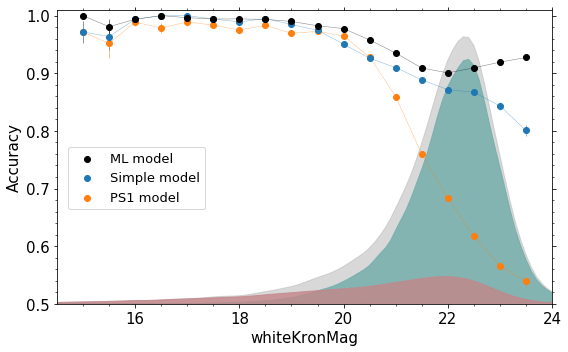

In [66]:
plot_ACU_curves(hst_tab[hst_det_mask][features], hst_tab[hst_det_mask], hst_GT[hst_det_mask], 
                figname='CV_Accuracy_HST.pdf', savefig=True, thre_method='info')

### Boot strap sampling

In [67]:
simple_decision_thresh = 9.2e-07 #  maximize acc on training set
ps1_decision_thresh = -0.05
hst_det_mask = (hst_tab.nDetections > 0)&(~np.isnan(hst_tab.iFPSFminusFKron))

simple_labels = np.logical_not(np.array(hst_tab["wwFPSFApDist"].loc[hst_det_mask]) < simple_decision_thresh).astype(int)
ps1_labels = np.logical_not(-1*np.array(hst_tab["iFPSFminusFKron"].loc[hst_det_mask]) < ps1_decision_thresh).astype(int)

In [68]:
hst_ml_y = hst_GT[np.array(hst_det_mask)]
hst_ml_X = hst_tab[hst_det_mask][features].values

In [69]:
rf_clf = RandomForestClassifier(n_estimators=400, 
                                    max_features=4,
                                    min_samples_leaf=2,
                                    n_jobs=-1)

binwidth = 0.5
Nboot = 100
n_splits = 10
mag_array = np.arange(15 , 23.5+binwidth, binwidth)
kron_mag = np.array(-2.5*np.log10(hst_tab['wwFKronFlux'].loc[hst_det_mask]/3631))
ap_mag = np.array(-2.5*np.log10(hst_tab['wwFApFlux'].loc[hst_det_mask]/3631))

simple_acc_arr = np.zeros((len(mag_array), n_splits))
ps1_acc_arr = np.zeros_like(simple_acc_arr)
ml_acc_arr = np.zeros_like(simple_acc_arr)

simple_scatter_arr = np.zeros((len(mag_array), n_splits*Nboot))
ps1_scatter_arr = np.zeros_like(simple_scatter_arr)
ml_scatter_arr = np.zeros_like(simple_scatter_arr)

cv = StratifiedKFold(n_splits=n_splits)

In [70]:
for cv_num, (train, test) in enumerate(cv.split(hst_ml_X, hst_ml_y)):
    print('.', end='')
    X_train, X_test, y_train, y_test = hst_ml_X[train], hst_ml_X[test], hst_ml_y[train], hst_ml_y[test]
    rf_clf.fit(X_train, y_train)
    ml_labels_cv = rf_clf.predict(X_test)
    simple_labels_cv = simple_labels[test]
    ps1_labels_cv = ps1_labels[test]
    
    for bin_num, binedge in enumerate(mag_array):
        bin_sources = np.where((ap_mag[test] >= binedge) & (ap_mag[test] < binedge + binwidth))
        simple_acc_arr[bin_num, cv_num] = accuracy_score(y_test[bin_sources], 
                                                 simple_labels_cv[bin_sources])
        ps1_acc_arr[bin_num, cv_num] = accuracy_score(y_test[bin_sources], 
                                                 ps1_labels_cv[bin_sources])
        ml_acc_arr[bin_num, cv_num] = accuracy_score(y_test[bin_sources], 
                                                 ml_labels_cv[bin_sources])
        simple_boot_acc =  np.empty(Nboot)
        ps1_boot_acc = np.empty_like(simple_boot_acc)
        ml_boot_acc = np.empty_like(simple_boot_acc)
        
        for i in range(Nboot):
            boot_sources = np.random.choice(bin_sources[0], len(bin_sources[0]), 
                                            replace=True)
            simple_boot_acc[i] = accuracy_score(y_test[boot_sources], 
                                                 simple_labels_cv[boot_sources])
            ps1_boot_acc[i] = accuracy_score(y_test[boot_sources], 
                                                 ps1_labels_cv[boot_sources])
            ml_boot_acc[i] = accuracy_score(y_test[boot_sources], 
                                                 ml_labels_cv[boot_sources])
            
        simple_scatter_arr[bin_num, np.arange(cv_num*Nboot, (cv_num+1)*Nboot, 1, dtype=int)] = simple_boot_acc
        ps1_scatter_arr[bin_num, np.arange(cv_num*Nboot, (cv_num+1)*Nboot, 1, dtype=int)] = ps1_boot_acc
        ml_scatter_arr[bin_num, np.arange(cv_num*Nboot, (cv_num+1)*Nboot, 1, dtype=int)] = ml_boot_acc

..........

In [71]:
GT = hst_ml_y
wwKronMag = kron_mag
wwApMag = ap_mag

star_norm = np.sum(GT==1)/len(GT)
gal_norm = np.sum(GT==0)/len(GT)

All_kde = stats.gaussian_kde(wwKronMag)
Star_kde = stats.gaussian_kde(wwKronMag[GT==1])
Gal_kde = stats.gaussian_kde(wwKronMag[GT==0])
n = (np.arange(12,25,0.01))
All_kde_pdf = All_kde(n)
Star_kde_pdf = Star_kde(n)*star_norm
Gal_kde_pdf = Gal_kde(n)*gal_norm

In [72]:
ML_acc_arr = np.mean(ml_acc_arr, axis=1)
dist_acc_arr = np.mean(simple_acc_arr, axis=1)
iminus_acc_arr = np.mean(ps1_acc_arr, axis=1)
ML_boot_scatt = np.percentile(ml_scatter_arr, [16, 84], axis=1)
dist_boot_scatt = np.percentile(simple_scatter_arr, [16, 84], axis=1)
iminus_boot_scatt = np.percentile(ps1_scatter_arr, [16, 84], axis=1)

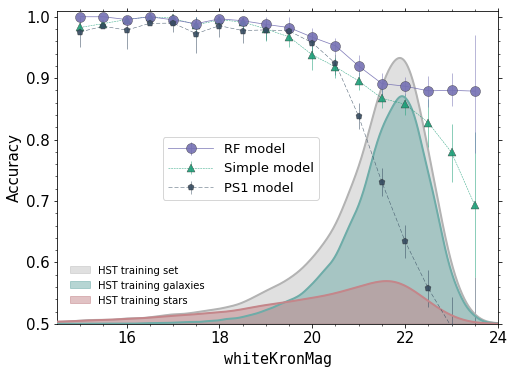

In [73]:
cmap = plt.get_cmap("Dark2")

color_dict = {'ml': cmap(0.33), 
              'sdss': cmap(0.66), 
              'simple': cmap(0.),
              'ps1': cmap(1.)}

color_dict = {'ml': cmap(0.33), 
              'sdss': cmap(0.66), 
              'simple': cmap(0.),
              'ps1': cmap(1.)}

# apple colors
color_dict = {'ml': "#0072c6", #"#1C1858",
              'sdss': "#5BC236", #"#00C78E",
              'simple': "#C864AF", #"#C70039",
              'ps1': "#C65400"}

# color blind friendly
color_dict = {'ml': '#0072b2', 
              'sdss': '#d55e00', 
              'simple': '#cc79a7',
              'ps1': '#009e73'}

# color brewer
color_dict = {'ml': '#7570b3', 
              'sdss': '#d95f02', 
              'simple': '#1b9e77',
              'ps1': '#34495e'}

ls_dict = {'ml': '-', 
              'sdss': '-.', 
              'simple': '--',
              'ps1': '--'}

lw_dict = {'ml': .75, 
              'sdss': .5, 
              'simple': .5, 
              'ps1': .5}

bias = 0.5

cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

fig, ax = plt.subplots(figsize=(7,5))

ax.vlines(mag_array, iminus_boot_scatt[0], iminus_boot_scatt[1], 
           color=color_dict['ps1'], alpha=0.5, linewidth=1, zorder=3)
ax.vlines(mag_array, dist_boot_scatt[0], dist_boot_scatt[1], 
           color=color_dict['simple'], alpha=0.5, linewidth=1, zorder=4)
ax.vlines(mag_array, ML_boot_scatt[0], ML_boot_scatt[1], 
           color=color_dict['ml'], alpha=0.5, linewidth=1, zorder=5)
ax.errorbar(mag_array, ML_acc_arr, color=color_dict['ml'], yerr=np.zeros_like(mag_array), 
            fmt='o', ms=10,  zorder=10, mew=0.4, mec="0.2", alpha=0.9, 
            ls=ls_dict['ml'], lw = lw_dict['ml'], label='RF model')
ax.errorbar(mag_array, dist_acc_arr, color=color_dict['simple'], yerr=np.zeros_like(mag_array), 
            fmt='^',ms=8, zorder=5, mew=0.4, mec="0.2", alpha=0.9, 
            ls=ls_dict['simple'], lw = lw_dict['simple'],  label='Simple model')
ax.errorbar(mag_array, iminus_acc_arr, color=color_dict['ps1'], yerr=np.zeros_like(mag_array),  
            fmt='p', ms=7, zorder=25, mew=0.4, mec="0.2", alpha=0.9, 
            ls=ls_dict['ps1'], lw = lw_dict['ps1'], dashes=(8, 4), label='PS1 model')

ax.fill(n, All_kde_pdf + bias, alpha=0.4, color="0.7", zorder=0, label="HST training set")
ax.fill(n, Gal_kde_pdf + bias, alpha=0.5, color=cmap_gal(0.25), zorder=1, label="HST training galaxies")
ax.fill(n, Star_kde_pdf + bias, alpha=0.5, color=cmap_star(0.25), zorder=2, label="HST training stars")
ax.plot(n, All_kde_pdf + bias, lw=2, color="0.7", zorder=3)
ax.plot(n, Gal_kde_pdf + bias, lw=2, color=cmap_gal(0.25), zorder=4)
ax.plot(n, Star_kde_pdf + bias, lw=2, color=cmap_star(0.25), zorder=5)

ax.set_ylim(bias,1.01)
ax.set_xlim(14.5, 24.0)

handles, labels = ax.get_legend_handles_labels()
leg_lines = ax.legend(handles[3:], labels[3:], 
                        bbox_to_anchor=(0.225, 0.375, 1., 0.102),
                        loc=3, fontsize=13, handlelength=3.5)
leg_kde = Legend(ax, handles[:3], labels[:3], 
                  bbox_to_anchor=(0.01, 0.03, 1., 0.102),
                  loc=3,fontsize=10,  frameon=False)
ax.add_artist(leg_kde)

ax.tick_params(labelsize = 15, which="both", top=True,  right=True)
ax.minorticks_on()
ax.set_xlabel('$\mathtt{whiteKronMag}$', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)

fig.subplots_adjust(right=0.975,top=0.985,bottom=0.115,left=0.1)
fig.savefig("../paper/Figures/CV_Accuracy_HST.pdf")

## Adjustments

Make a slight alteration to the primary calculation in order to retain information about the individual folds and the statistics computed from each of them.

classifier = RandomForestClassifier(n_estimators=400, 
                                    max_features=4,
                                    min_samples_leaf=2,
                                    n_jobs=-1)

In [74]:
def get_CV_preds(hst_tab, hst_det_mask, feats, n_splits=10, rs=23):
    ps1_preds = np.array(hst_tab["iFPSFminusFKron"].loc[hst_det_mask])
    simple_preds = np.array(hst_tab["wwFPSFApDist"].loc[hst_det_mask])
    X_hst = np.array(hst_tab[feats].loc[hst_det_mask])
    y_hst = np.array(hst_tab["MU_CLASS"].loc[hst_det_mask] - 1, dtype=int)
    rf_preds = np.empty_like(simple_preds)
    cv = StratifiedKFold(n_splits=n_splits, random_state=rs)
    for train, test in cv.split(X_hst, y_hst):
        rf_preds[test] = classifier.fit(X_hst[train], 
                                        y_hst[train]).predict_proba(X_hst[test])[:,1]
    return y_hst, ps1_preds, simple_preds, rf_preds

In [75]:
y_hst, ps1_preds, simple_preds, rf_preds = get_CV_preds(hst_tab, hst_det_mask, features, n_splits=10, rs=23)

/home/xhall/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [76]:
def calc_fom(fpr, tpr, thresh):
    return interp(0.005, fpr, tpr)

In [77]:
def calc_summary_stats(y_hst, ps1_preds, simple_preds, rf_preds, 
                       ps1_ct = -0.05, 
                       simple_ct = 9.2e-7,
                       rf_ct = 0.5,
                       make_plot = False,
                       fold_plot = True):
    ps1_fpr, ps1_tpr, ps1_thresh = roc_curve(y_hst, -1*ps1_preds)
    ps1_fom = calc_fom(ps1_fpr, ps1_tpr, ps1_thresh)
    ps1_auc = roc_auc_score(y_hst, -1*ps1_preds)
    ps1_acc = accuracy_score(y_hst, ps1_preds <= ps1_ct)
    
    simple_fpr, simple_tpr, simple_thresh = roc_curve(y_hst, simple_preds)
    simple_fom = calc_fom(simple_fpr, simple_tpr, simple_thresh)
    simple_auc = roc_auc_score(y_hst, simple_preds)
    simple_acc = accuracy_score(y_hst, simple_preds >= simple_ct)
    
    rf_fpr, rf_tpr, rf_thresh = roc_curve(y_hst, rf_preds)
    rf_fom = calc_fom(rf_fpr, rf_tpr, rf_thresh)
    rf_auc = roc_auc_score(y_hst, rf_preds)
    rf_acc = accuracy_score(y_hst, rf_preds >= rf_ct)
    
    if make_plot:
        lw = 0.5 if fold_plot else 2
        alpha = 0.4 if fold_plot else 1
        for ax in [main_ax, axins]:
            ax.plot(rf_fpr, rf_tpr, lw=lw, color="#7570b3", alpha=alpha)
            ax.plot(simple_fpr, simple_tpr, lw=lw, color="#1b9e77", alpha=alpha)
            ax.plot(ps1_fpr, ps1_tpr, lw=lw, color="#34495e", alpha=alpha)

    
    return ps1_auc, ps1_acc, ps1_fom, simple_auc, simple_acc, simple_fom, rf_auc, rf_acc, rf_fom

/home/xhall/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


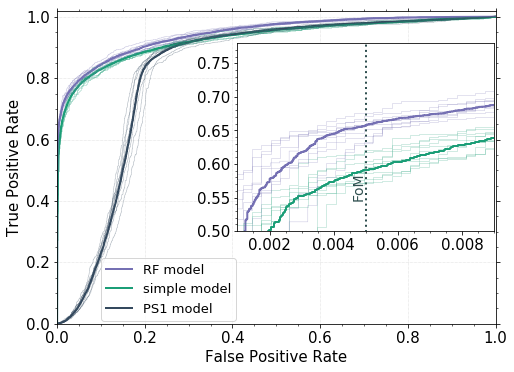

In [78]:
fig, main_ax = plt.subplots(figsize=(7,5))

axins = inset_axes(main_ax, width="58.5%",  
                   height="60%", loc=3,
                   bbox_to_anchor=(0.4, 0.28, 1., 1.),
                   bbox_transform=main_ax.transAxes)


cv = StratifiedKFold(n_splits=10, random_state=23)
X_hst = np.array(hst_tab[features].loc[hst_det_mask])

cv_summary_stats = calc_summary_stats(y_hst, ps1_preds, simple_preds, rf_preds, 
                                      make_plot=True, fold_plot=False)

for fold_num, (train, test) in enumerate(cv.split(X_hst, y_hst)):
    fold_results = calc_summary_stats(y_hst[test], ps1_preds[test], 
                                      simple_preds[test], rf_preds[test], make_plot=True)
    if fold_num == 0:
        each_fold_sum_stats = fold_results
    else:
        each_fold_sum_stats = np.vstack((each_fold_sum_stats, fold_results))



main_ax.set_xlim(0,1) 
main_ax.set_ylim(0,1.02)
main_ax.grid(alpha=0.5, lw=0.5, c='grey', linestyle=':') 
main_ax.tick_params(which="both", top=True, right=True, labelsize = 15)
main_ax.minorticks_on()
main_ax.set_xlabel('False Positive Rate', fontsize=15)
main_ax.set_ylabel('True Positive Rate', fontsize=15)

# legend stuff
main_ax.plot([1e6,1e6], [1e6,1e6], lw=2, 
        color="#7570b3", alpha=1,
        label='RF model')
main_ax.plot([1e6,1e6], [1e6,1e6], lw=2, 
        color="#1b9e77", alpha=1,
        label='simple model')
main_ax.plot([1e6,1e6], [1e6,1e6], lw=2, 
        color="#34495e", alpha=1,
        label='PS1 model')
main_ax.legend(loc=3, borderaxespad=0, fontsize=13,
               bbox_to_anchor=(0.1, 0.01, 1., 0.102), )
# SDSS color = #7570b3

        
# axins.vlines([5e-3], 1e-3, 1, color='grey', lw=0.5)
axins.vlines([5e-3], 1e-3, 1, 
          linestyles=":", 
          color='DarkSlateGrey', lw=2)
axins.text(5e-3, 0.55, 'FoM', 
        color='DarkSlateGrey', 
        rotation=90, ha="right", fontsize=14)

axins.set_xlim(1e-3, 9e-3)
axins.set_ylim(0.5, 0.78)
axins.tick_params(labelsize = 15)
axins.minorticks_on()

fig.subplots_adjust(right=0.97,top=0.98,bottom=0.11,left=0.1)
#fig.savefig("/Users/adamamiller/Desktop/CV_ROC_HST.pdf")
fig.savefig("../paper/Figures/CV_ROC_HST.pdf")

In [79]:
print(r"""
RF & {0:.3f} $\pm$ {9:.3f} & {1:.3f} $\pm$ {10:.3f} & {2:.3f} $\pm$ {11:.3f} \\
simple & {3:.3f} $\pm$ {12:.3f} & {4:.3f} $\pm$ {13:.3f} & {5:.3f} $\pm$ {14:.3f} \\
PS1 & {6:.3f} $\pm$ {15:.3f} & {7:.3f} $\pm$ {16:.3f} & {8:.3f} $\pm$ {17:.3f} \\
""".format(*np.append(cv_summary_stats[::-1], np.std(each_fold_sum_stats, ddof=1, axis=0)[::-1])))


RF & 0.657 $\pm$ 0.016 & 0.918 $\pm$ 0.003 & 0.945 $\pm$ 0.003 \\
simple & 0.591 $\pm$ 0.017 & 0.887 $\pm$ 0.007 & 0.930 $\pm$ 0.003 \\
PS1 & 0.002 $\pm$ 0.001 & 0.809 $\pm$ 0.008 & 0.827 $\pm$ 0.009 \\

